### This notebook looks at the impact of systematically deleting SC ...the INNER connectivity i.e., from ntwx A to itself, ntwx B to itself when ntwx X is isolated ...

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
from collections import Counter

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
import pickle

In [5]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [6]:
import re

In [7]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [8]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [9]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [10]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min, sys: 406 ms, total: 1min
Wall time: 1min 8s


In [11]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.41 s, sys: 76.2 ms, total: 1.49 s
Wall time: 1.49 s


In [12]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [13]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [14]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
    ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
    all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
    ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
    all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
    all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
    all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
    ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
    all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
    all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
    all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 2min 35s, sys: 3.02 s, total: 2min 38s
Wall time: 3min 28s


In [15]:
# for now deal with avg fc of DMN lesion only (across all ntwx) ...
# This is INNER connectivity ... i.e., the average ntwx conn to itself (so Vis to Vis, DMN to DMN, etc)

# all_subs_og_whobpyt
# all_subs_dmn_lesion

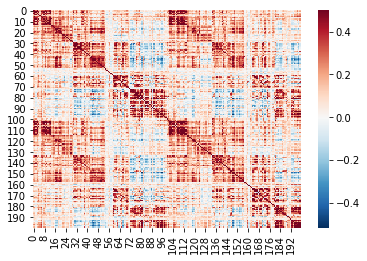

In [16]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

In [17]:
def ntwx_only_fc(fc, sub, a,b,c,d):
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_rh = fc[sub][c:d, c:d]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    
#     mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
#     mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2)
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh))/2 + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2
    return mean_fc

In [18]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

In [19]:
Ntwx = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

#### original whobpyt

In [20]:
%%time

# original whobpyt

org_whobpyt_vis_mean_fc_all_subs = []
org_whobpyt_sommot_mean_fc_all_subs = []
org_whobpyt_dorsattn_mean_fc_all_subs = []
org_whobpyt_ventattn_mean_fc_all_subs = []
org_whobpyt_limbic_mean_fc_all_subs = []
org_whobpyt_fpn_mean_fc_all_subs = []
org_whobpyt_dmn_mean_fc_all_subs = []

for i in range(200):
    
    temp_vis = ntwx_only_fc(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    org_whobpyt_vis_mean_fc_all_subs.append(temp_vis)
    
    temp_sommot = ntwx_only_fc(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    org_whobpyt_sommot_mean_fc_all_subs.append(temp_sommot)

    temp_dorsattn = ntwx_only_fc(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    org_whobpyt_dorsattn_mean_fc_all_subs.append(temp_dorsattn)

    temp_ventattn = ntwx_only_fc(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    org_whobpyt_ventattn_mean_fc_all_subs.append(temp_ventattn)

    temp_limbic = ntwx_only_fc(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    org_whobpyt_limbic_mean_fc_all_subs.append(temp_limbic)

    temp_fpn = ntwx_only_fc(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    org_whobpyt_fpn_mean_fc_all_subs.append(temp_fpn)

    temp_dmn = ntwx_only_fc(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    org_whobpyt_dmn_mean_fc_all_subs.append(temp_dmn)

    
    
    
org_whobpyt_vis_mean_fc_all_subs_mean = org_whobpyt_vis_mean_fc_all_subs.copy()
org_whobpyt_sommot_mean_fc_all_subs_mean = org_whobpyt_sommot_mean_fc_all_subs.copy()
org_whobpyt_dorsattn_mean_fc_all_subs_mean = org_whobpyt_dorsattn_mean_fc_all_subs.copy()
org_whobpyt_ventattn_mean_fc_all_subs_mean = org_whobpyt_ventattn_mean_fc_all_subs.copy()
org_whobpyt_limbic_mean_fc_all_subs_mean = org_whobpyt_limbic_mean_fc_all_subs.copy()
org_whobpyt_fpn_mean_fc_all_subs_mean = org_whobpyt_fpn_mean_fc_all_subs.copy()
org_whobpyt_dmn_mean_fc_all_subs_mean = org_whobpyt_dmn_mean_fc_all_subs.copy()


org_whobpyt_means = [org_whobpyt_vis_mean_fc_all_subs_mean,
org_whobpyt_sommot_mean_fc_all_subs_mean,
org_whobpyt_dorsattn_mean_fc_all_subs_mean,
org_whobpyt_ventattn_mean_fc_all_subs_mean,
org_whobpyt_limbic_mean_fc_all_subs_mean,
org_whobpyt_fpn_mean_fc_all_subs_mean,
org_whobpyt_dmn_mean_fc_all_subs_mean]

CPU times: user 136 ms, sys: 33.2 ms, total: 169 ms
Wall time: 153 ms


In [21]:
ntwx_labels = ['Vis','SomMot', 'DorsAttn', 'VentAttn', 'Limbic','FPN','DMN']

In [52]:
org_whobpyt_means[0]

[0.38200159356833324,
 0.5281912323166373,
 0.5223039146353133,
 0.5790754207221558,
 0.4822468039602803,
 0.43784491741779635,
 0.48438755039108977,
 0.5852364269915822,
 0.4565704216221961,
 0.25754866032154505,
 0.5203442656041685,
 0.5449810471808242,
 0.5076365549253943,
 0.5674274830871835,
 0.3954168877438081,
 0.518481507737081,
 0.525841322804449,
 0.3071711213886651,
 0.44950938684831243,
 0.5919197414892635,
 0.5726251045001363,
 0.48676965433393915,
 0.2850313030353716,
 0.3877546857591141,
 0.45176874922519217,
 0.5555816599523957,
 0.528789013058713,
 0.5253627661168452,
 0.4414357305654413,
 0.4622989888652015,
 0.3520324147873532,
 0.4952375468084743,
 0.3150420690073869,
 0.42076016839236696,
 0.5080602359323988,
 0.5394836611676289,
 0.37264455706193994,
 0.3639986071996668,
 0.39277894062334057,
 0.5293144750975283,
 0.4519461608956753,
 0.5374659664488814,
 0.2912960218818451,
 0.5374554629653976,
 0.4166111898262657,
 0.47863866997780213,
 0.5987657699555129,
 0.45

In [22]:
def func_for_inner_ntwx_connectivity(all_subs_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = ntwx_only_fc(all_subs_ntwx_lesion, i, 0, 14, 100, 115)
        ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = ntwx_only_fc(all_subs_ntwx_lesion, i, 14, 30, 115, 134)
        ntwx_lesion_whobpyt_sommot_mean_fc_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 30, 43, 134, 147)
        ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 43, 54, 147, 158)
        ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = ntwx_only_fc(all_subs_ntwx_lesion, i, 54, 60, 158, 164)
        ntwx_lesion_whobpyt_limbic_mean_fc_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = ntwx_only_fc(all_subs_ntwx_lesion, i, 60, 73, 164, 181)
        ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = ntwx_only_fc(all_subs_ntwx_lesion, i, 73, 100, 181, 200)
        ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(ntwx_lesion_temp_dmn)


    ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_vis_mean_fc_all_subs)
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_sommot_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_limbic_mean_fc_all_subs)
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_fpn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dmn_mean_fc_all_subs)


    ntwx_lesion_means_all_subs = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs,ntwx_lesion_whobpyt_sommot_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs,ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_limbic_mean_fc_all_subs,ntwx_lesion_whobpyt_fpn_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dmn_mean_fc_all_subs]
    
    ntwx_lesion_whobpyt_means = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

In [23]:
org2_whobpyt_means, org2_all_subs = func_for_inner_ntwx_connectivity(all_subs_og_whobpyt)

In [47]:
org_whobpyt_means[0]

[0.38200159356833324,
 0.5281912323166373,
 0.5223039146353133,
 0.5790754207221558,
 0.4822468039602803,
 0.43784491741779635,
 0.48438755039108977,
 0.5852364269915822,
 0.4565704216221961,
 0.25754866032154505,
 0.5203442656041685,
 0.5449810471808242,
 0.5076365549253943,
 0.5674274830871835,
 0.3954168877438081,
 0.518481507737081,
 0.525841322804449,
 0.3071711213886651,
 0.44950938684831243,
 0.5919197414892635,
 0.5726251045001363,
 0.48676965433393915,
 0.2850313030353716,
 0.3877546857591141,
 0.45176874922519217,
 0.5555816599523957,
 0.528789013058713,
 0.5253627661168452,
 0.4414357305654413,
 0.4622989888652015,
 0.3520324147873532,
 0.4952375468084743,
 0.3150420690073869,
 0.42076016839236696,
 0.5080602359323988,
 0.5394836611676289,
 0.37264455706193994,
 0.3639986071996668,
 0.39277894062334057,
 0.5293144750975283,
 0.4519461608956753,
 0.5374659664488814,
 0.2912960218818451,
 0.5374554629653976,
 0.4166111898262657,
 0.47863866997780213,
 0.5987657699555129,
 0.45

In [42]:
len(org2_whobpyt_means)

7

In [48]:
org2_whobpyt_means[0]

0.4762078600105418

In [49]:
org_whobpyt_df = pd.DataFrame(org2_all_subs,index=ntwx_labels)

org_whobpyt_df = org_whobpyt_df.T

# org_whobpyt_df

In [50]:
vis_lesion_whobpyt_means, vis_all_subs = func_for_inner_ntwx_connectivity(all_subs_vis_lesion)
sommot_lesion_whobpyt_means, sommot_all_subs = func_for_inner_ntwx_connectivity(all_subs_sommot_lesion)
dorsattn_lesion_whobpyt_means, dorsattn_all_subs = func_for_inner_ntwx_connectivity(all_subs_dorsattn_lesion)
ventattn_lesion_whobpyt_means, ventattn_all_subs = func_for_inner_ntwx_connectivity(all_subs_ventattn_lesion)
limbic_lesion_whobpyt_means, limbic_all_subs = func_for_inner_ntwx_connectivity(all_subs_limbic_lesion)
fpn_lesion_whobpyt_means, fpn_all_subs = func_for_inner_ntwx_connectivity(all_subs_fpn_lesion)
dmn_lesion_whobpyt_means, dmn_all_subs = func_for_inner_ntwx_connectivity(all_subs_dmn_lesion)

In [51]:
vis_all_subs[0]

[0.35189309813428643,
 0.5623248226803339,
 0.6120562735915247,
 0.6053603099895473,
 0.5621571643950329,
 0.10984626436057779,
 0.5994741514317528,
 0.7295705799646335,
 0.551231052265005,
 0.1455702154274436,
 0.6693247768298385,
 0.6880060075727426,
 0.6197052371413407,
 0.6097212559022323,
 0.49956930880871747,
 0.6467693335850573,
 0.10042575048704937,
 0.3176138397075429,
 0.5307188327448399,
 0.6410424320996948,
 0.601906212231377,
 0.12502019159142513,
 0.22613837897948763,
 0.31358825896972375,
 0.5632964323081031,
 0.06548500127096996,
 0.5902014824415767,
 0.606983276311424,
 0.1650816312233167,
 0.09699716306884455,
 0.34773998045992804,
 0.6121241452640007,
 0.32790025101776166,
 0.22143917949157832,
 0.5778324162841345,
 0.5467970053190472,
 0.5099445964832536,
 0.3502691796610658,
 0.2803007607548463,
 0.6057207429527629,
 0.478393894320529,
 0.06768385343324486,
 0.32134295987862505,
 0.6035157510534759,
 0.5118628805635983,
 0.6079739898354058,
 0.5809087213117292,
 0.

In [26]:
len(vis_all_subs[0])

200

In [27]:
len(vis_all_subs[0])

200

In [28]:
import statsmodels.api as sm
import pingouin as pg

In [29]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

### `vis lesion` stats

In [58]:
for i in range(7):
    
    condition_A = org_whobpyt_means[i].copy()
    condition_B = vis_all_subs[i].copy()
    
    data = []

    for subject in range(1, 201):
            data.append([subject, 'A', condition_A[subject-1]])
            data.append([subject, 'B', condition_B[subject-1]])
            
    df = pd.DataFrame(data, columns=['Subject', 'Condition', 'Dependent_Variable'])
    
    rm_anova = pg.rm_anova(data=df, dv='Dependent_Variable', within='Condition', subject='Subject')
    posthoc = pg.pairwise_ttests(data=df, dv='Dependent_Variable', within='Condition', subject='Subject', padjust='holm')

    print('VIS Lesion - {0} to itself ntwx \n'.format(Ntwx_labels[i]))
    print(rm_anova, '\n')
    print(posthoc, '\n')
    print('---------------------------------- \n')


VIS Lesion - Vis to itself ntwx 

      Source  ddof1  ddof2         F    p-unc       np2  eps
0  Condition      1    199  7.718269  0.00599  0.037337  1.0 

    Contrast  A  B  Paired  Parametric         T    dof       Tail    p-unc  \
0  Condition  A  B    True        True  2.778177  199.0  two-sided  0.00599   

    BF10    hedges  
0  3.306  0.218768   

---------------------------------- 

VIS Lesion - SomMot to itself ntwx 

      Source  ddof1  ddof2          F     p-unc       np2  eps
0  Condition      1    199  21.105586  0.000008  0.095888  1.0 

    Contrast  A  B  Paired  Parametric         T    dof       Tail     p-unc  \
0  Condition  A  B    True        True  4.594082  199.0  two-sided  0.000008   

       BF10    hedges  
0  1567.591  0.256194   

---------------------------------- 

VIS Lesion - DorsAttn to itself ntwx 

      Source  ddof1  ddof2          F         p-unc       np2  eps
0  Condition      1    199  78.211989  4.982970e-16  0.282138  1.0 

    Contrast  

### `smt lesion` stats

In [31]:
for i in range(7):
    
    condition_A = org_whobpyt_means[i].copy()
    condition_B = sommot_all_subs[i].copy()
    
    data = []

    for subject in range(1, 201):
            data.append([subject, 'A', condition_A[subject-1]])
            data.append([subject, 'B', condition_B[subject-1]])
            
    df = pd.DataFrame(data, columns=['Subject', 'Condition', 'Dependent_Variable'])
    
    rm_anova = pg.rm_anova(data=df, dv='Dependent_Variable', within='Condition', subject='Subject')
    posthoc = pg.pairwise_ttests(data=df, dv='Dependent_Variable', within='Condition', subject='Subject', padjust='holm')

    print('SMT Lesion - {0} to itself ntwx \n'.format(Ntwx_labels[i]))
    print(rm_anova, '\n')
    print(posthoc, '\n')
    print('---------------------------------- \n')


SMT Lesion - Vis to itself ntwx 

      Source  ddof1  ddof2         F     p-unc      np2  eps
0  Condition      1    199  4.011484  0.046548  0.01976  1.0 

    Contrast  A  B  Paired  Parametric         T    dof       Tail     p-unc  \
0  Condition  A  B    True        True -2.002869  199.0  two-sided  0.046548   

   BF10    hedges  
0  0.56 -0.072161   

---------------------------------- 

SMT Lesion - SomMot to itself ntwx 

      Source  ddof1  ddof2          F         p-unc       np2  eps
0  Condition      1    199  83.897531  6.452149e-17  0.296565  1.0 

    Contrast  A  B  Paired  Parametric        T    dof       Tail  \
0  Condition  A  B    True        True  9.15956  199.0  two-sided   

          p-unc       BF10    hedges  
0  6.452149e-17  8.256e+13  0.763585   

---------------------------------- 

SMT Lesion - DorsAttn to itself ntwx 

      Source  ddof1  ddof2         F     p-unc       np2  eps
0  Condition      1    199  5.739068  0.017518  0.028031  1.0 

    Cont

### `dan lesion` stats

In [32]:
for i in range(7):
    
    condition_A = org_whobpyt_means[i].copy()
    condition_B = dorsattn_all_subs[i].copy()
    
    data = []

    for subject in range(1, 201):
            data.append([subject, 'A', condition_A[subject-1]])
            data.append([subject, 'B', condition_B[subject-1]])
            
    df = pd.DataFrame(data, columns=['Subject', 'Condition', 'Dependent_Variable'])
    
    rm_anova = pg.rm_anova(data=df, dv='Dependent_Variable', within='Condition', subject='Subject')
    posthoc = pg.pairwise_ttests(data=df, dv='Dependent_Variable', within='Condition', subject='Subject', padjust='holm')

    print('DAN Lesion - {0} to itself ntwx \n'.format(Ntwx_labels[i]))
    print(rm_anova, '\n')
    print(posthoc, '\n')
    print('---------------------------------- \n')


DAN Lesion - Vis to itself ntwx 

      Source  ddof1  ddof2          F     p-unc       np2  eps
0  Condition      1    199  19.377312  0.000017  0.088733  1.0 

    Contrast  A  B  Paired  Parametric         T    dof       Tail     p-unc  \
0  Condition  A  B    True        True  4.401967  199.0  two-sided  0.000017   

      BF10    hedges  
0  722.681  0.330016   

---------------------------------- 

DAN Lesion - SomMot to itself ntwx 

      Source  ddof1  ddof2          F     p-unc       np2  eps
0  Condition      1    199  16.565079  0.000068  0.076845  1.0 

    Contrast  A  B  Paired  Parametric         T    dof       Tail     p-unc  \
0  Condition  A  B    True        True  4.070022  199.0  two-sided  0.000068   

      BF10    hedges  
0  202.343  0.266812   

---------------------------------- 

DAN Lesion - DorsAttn to itself ntwx 

      Source  ddof1  ddof2          F         p-unc       np2  eps
0  Condition      1    199  169.81313  1.805244e-28  0.460431  1.0 

    Co

### `van lesion` stats

In [41]:
len(org_whobpyt_means)

7

In [33]:
for i in range(7):
    
    condition_A = org_whobpyt_means[i].copy()
    condition_B = ventattn_all_subs[i].copy()
    
    data = []

    for subject in range(1, 201):
            data.append([subject, 'A', condition_A[subject-1]])
            data.append([subject, 'B', condition_B[subject-1]])
            
    df = pd.DataFrame(data, columns=['Subject', 'Condition', 'Dependent_Variable'])
    
    rm_anova = pg.rm_anova(data=df, dv='Dependent_Variable', within='Condition', subject='Subject')
    posthoc = pg.pairwise_ttests(data=df, dv='Dependent_Variable', within='Condition', subject='Subject', padjust='holm')

    print('VAN Lesion - {0} to itself ntwx \n'.format(Ntwx_labels[i]))
    print(rm_anova, '\n')
    print(posthoc, '\n')
    print('---------------------------------- \n')


VAN Lesion - Vis to itself ntwx 

      Source  ddof1  ddof2         F     p-unc       np2  eps
0  Condition      1    199  0.246109  0.620376  0.001235  1.0 

    Contrast  A  B  Paired  Parametric         T    dof       Tail     p-unc  \
0  Condition  A  B    True        True -0.496094  199.0  two-sided  0.620376   

    BF10    hedges  
0  0.089 -0.020867   

---------------------------------- 

VAN Lesion - SomMot to itself ntwx 

      Source  ddof1  ddof2         F     p-unc       np2  eps
0  Condition      1    199  8.832592  0.003324  0.042499  1.0 

    Contrast  A  B  Paired  Parametric         T    dof       Tail     p-unc  \
0  Condition  A  B    True        True  2.971968  199.0  two-sided  0.003324   

    BF10   hedges  
0  5.604  0.13781   

---------------------------------- 

VAN Lesion - DorsAttn to itself ntwx 

      Source  ddof1  ddof2          F    p-unc       np2  eps
0  Condition      1    199  19.069629  0.00002  0.087447  1.0 

    Contrast  A  B  Paired  Pa

### `lim lesion` stats

In [34]:
for i in range(7):
    
    condition_A = org_whobpyt_means[i].copy()
    condition_B = limbic_all_subs[i].copy()
    
    data = []

    for subject in range(1, 201):
            data.append([subject, 'A', condition_A[subject-1]])
            data.append([subject, 'B', condition_B[subject-1]])
            
    df = pd.DataFrame(data, columns=['Subject', 'Condition', 'Dependent_Variable'])
    
    rm_anova = pg.rm_anova(data=df, dv='Dependent_Variable', within='Condition', subject='Subject')
    posthoc = pg.pairwise_ttests(data=df, dv='Dependent_Variable', within='Condition', subject='Subject', padjust='holm')

    print('LIM Lesion - {0} to itself ntwx \n'.format(Ntwx_labels[i]))
    print(rm_anova, '\n')
    print(posthoc, '\n')
    print('---------------------------------- \n')


LIM Lesion - Vis to itself ntwx 

      Source  ddof1  ddof2         F     p-unc       np2  eps
0  Condition      1    199  0.132221  0.716527  0.000664  1.0 

    Contrast  A  B  Paired  Parametric         T    dof       Tail     p-unc  \
0  Condition  A  B    True        True -0.363622  199.0  two-sided  0.716527   

    BF10    hedges  
0  0.084 -0.008789   

---------------------------------- 

LIM Lesion - SomMot to itself ntwx 

      Source  ddof1  ddof2         F     p-unc       np2  eps
0  Condition      1    199  4.386259  0.037496  0.021566  1.0 

    Contrast  A  B  Paired  Parametric        T    dof       Tail     p-unc  \
0  Condition  A  B    True        True -2.09434  199.0  two-sided  0.037496   

    BF10    hedges  
0  0.671 -0.032121   

---------------------------------- 

LIM Lesion - DorsAttn to itself ntwx 

      Source  ddof1  ddof2         F     p-unc       np2  eps
0  Condition      1    199  0.012626  0.910647  0.000063  1.0 

    Contrast  A  B  Paired  Pa

### `fpn lesion` stats

In [35]:
for i in range(7):
    
    condition_A = org_whobpyt_means[i].copy()
    condition_B = fpn_all_subs[i].copy()
    
    data = []

    for subject in range(1, 201):
            data.append([subject, 'A', condition_A[subject-1]])
            data.append([subject, 'B', condition_B[subject-1]])
            
    df = pd.DataFrame(data, columns=['Subject', 'Condition', 'Dependent_Variable'])
    
    rm_anova = pg.rm_anova(data=df, dv='Dependent_Variable', within='Condition', subject='Subject')
    posthoc = pg.pairwise_ttests(data=df, dv='Dependent_Variable', within='Condition', subject='Subject', padjust='holm')

    print('FPN Lesion - {0} to itself ntwx \n'.format(Ntwx_labels[i]))
    print(rm_anova, '\n')
    print(posthoc, '\n')
    print('---------------------------------- \n')


FPN Lesion - Vis to itself ntwx 

      Source  ddof1  ddof2          F     p-unc       np2  eps
0  Condition      1    199  16.282662  0.000078  0.075634  1.0 

    Contrast  A  B  Paired  Parametric         T    dof       Tail     p-unc  \
0  Condition  A  B    True        True -4.035178  199.0  two-sided  0.000078   

    BF10    hedges  
0  177.9 -0.112061   

---------------------------------- 

FPN Lesion - SomMot to itself ntwx 

      Source  ddof1  ddof2        F     p-unc       np2  eps
0  Condition      1    199  7.06066  0.008519  0.034265  1.0 

    Contrast  A  B  Paired  Parametric        T    dof       Tail     p-unc  \
0  Condition  A  B    True        True -2.65719  199.0  two-sided  0.008519   

    BF10    hedges  
0  2.418 -0.050013   

---------------------------------- 

FPN Lesion - DorsAttn to itself ntwx 

      Source  ddof1  ddof2         F    p-unc       np2  eps
0  Condition      1    199  0.627466  0.42923  0.003143  1.0 

    Contrast  A  B  Paired  Para

### `dmn lesion` stats

In [36]:
for i in range(7):
    
    condition_A = org_whobpyt_means[i].copy()
    condition_B = dmn_all_subs[i].copy()
    
    data = []

    for subject in range(1, 201):
            data.append([subject, 'A', condition_A[subject-1]])
            data.append([subject, 'B', condition_B[subject-1]])
            
    df = pd.DataFrame(data, columns=['Subject', 'Condition', 'Dependent_Variable'])
    
    rm_anova = pg.rm_anova(data=df, dv='Dependent_Variable', within='Condition', subject='Subject')
    posthoc = pg.pairwise_ttests(data=df, dv='Dependent_Variable', within='Condition', subject='Subject', padjust='holm')

    print('DMN Lesion - {0} to itself ntwx \n'.format(Ntwx_labels[i]))
    print(rm_anova, '\n')
    print(posthoc, '\n')
    print('---------------------------------- \n')


DMN Lesion - Vis to itself ntwx 

      Source  ddof1  ddof2          F         p-unc       np2  eps
0  Condition      1    199  28.538065  2.499387e-07  0.125421  1.0 

    Contrast  A  B  Paired  Parametric         T    dof       Tail  \
0  Condition  A  B    True        True -5.342103  199.0  two-sided   

          p-unc       BF10    hedges  
0  2.499387e-07  4.096e+04 -0.127867   

---------------------------------- 

DMN Lesion - SomMot to itself ntwx 

      Source  ddof1  ddof2          F         p-unc       np2  eps
0  Condition      1    199  26.532288  6.213981e-07  0.117643  1.0 

    Contrast  A  B  Paired  Parametric        T    dof       Tail  \
0  Condition  A  B    True        True -5.15095  199.0  two-sided   

          p-unc       BF10    hedges  
0  6.213981e-07  1.716e+04 -0.073907   

---------------------------------- 

DMN Lesion - DorsAttn to itself ntwx 

      Source  ddof1  ddof2          F     p-unc       np2  eps
0  Condition      1    199  12.624337  0.

In [ ]:
# Next step: re-introduce sc for each of the other networks 